# Final XGB Model Training and SHAP computation -- CDiff Dataset

**Authors:** 
* Lin Lee Cheong<br>
* Tesfagabir Meharizghi<br>

**Last Updated: 03/18/2021**

In this jupyter notebook, we trained XGB models by manually tuning their parameters to get the best performance and explainability scores from the CDiff dataset.

Tasks:
- Training XGB models with the specified parameters and dataset
- Computing different model performance measures such as AUCs, intersection similarity, etc.
- Visualizing global and local SHAP scores

Outputs:
- The following artifacts are saved:
    * Model artifacts
    * SHAP values and their corresponding scores for the specified number of val/test examples

Model Architecture Used:
- XGB

Dataset:
- CMSAI CDiff Dataset

Data Processing:
- In this final experiment, we used downsampled version of the training dataset to balance the number positives and negatives.
- The training split uses all the positives from all months of data (but the negatives are downsampled)
- Removed all the patients that are found in val/test splits to avoid data leakage
- Val/Test datasets are only from one month of data (`20110101`) - highly imbalanced

In [1]:
# pip install nb-black
#! pip install botocore==1.12.201

#! pip install shap
#! pip install xgboost

In [4]:
%load_ext lab_black

%load_ext autoreload

%autoreload 2

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import sys

sys.path.append("../")

import os
import time
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.inspection import permutation_importance
import re
from scipy import stats
import json

#!pip install -e git+https://github.com/changyaochen/rbo.git@master#egg=rbo
# import rbo

from urllib.parse import urlparse
import tarfile
import pickle
import shutil
from collections import Counter, defaultdict, OrderedDict

import shap
import xgboost as xgb

import sagemaker
import boto3
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.image_uris import retrieve

import xgboost_utils as xgb_utils
import shap_jacc_utils as sj_utils

## XGB Model Training

### Constants

In [6]:
# Whether to train model
TRAIN_MODEL = False

# Whether to preprocess data
PREPROCESS_DATA = False

# Whether to save SHAP scores
SAVE_SHAP_OUTPUT = True

# Whether to ouput SHAP explainer expected value
OUTPUT_SHAP_EXPLAINER = True

# Whether to shuffle val & test dataset for shap visualization purposes
SHUFFLE = False

USE_FREQ = True  # Whether to use feature frequencies or one-hot for data preprocessing

# Number of rows to use
nrows = 1e9

target_colname = "d_00845"
uid_colname = "patient_id"
target_value = "1"

dataset = "AE_CDiff"
model_name = "xgb"

# SHAP related constants
N_BACKGROUND = 300  # Number of background examples
BACKGROUND_NEGATIVE_ONLY = True  # If negative examples are used as background
BACKGROUND_POSITIVE_ONLY = False  # If positive examples are used as background
TEST_POSITIVE_ONLY = False  # If only positive examples are selected
IS_TEST_RANDOM = (
    False  # If random test/val examples are selected for shap value computation
)
SORT_SHAP_VALUES = False  # Whether to sort per-patient shap values for visualization

SHAP_SCORE_ABSOLUTE = True  # Whether to consider the absolute value of a shap score #TODO: Check this before running.

seq_len = 100
min_freq = 1000

DATA_TYPE = "original"  # "downsampled"
FNAME = "20110101"  # "all"

train_data_path = f"./output-mix/AE_CDiff/{seq_len}/{DATA_TYPE}/lstm-att-lrp/splits/{FNAME}/{min_freq}/train_balanced.csv"
valid_data_path = f"./output-mix/AE_CDiff/{seq_len}/{DATA_TYPE}/lstm-att-lrp/splits/{FNAME}/{min_freq}/val.csv"
test_data_path = f"./output-mix/AE_CDiff/{seq_len}/{DATA_TYPE}/lstm-att-lrp/splits/{FNAME}/{min_freq}/test.csv"
examples_path = f"./output-mix/AE_CDiff/{seq_len}/{DATA_TYPE}/lstm-att-lrp/splits/{FNAME}/{min_freq}/visualized_test_patients.txt"
vocab_path = f"./output-mix/AE_CDiff/{seq_len}/{DATA_TYPE}/lstm-att-lrp/splits/{FNAME}/{min_freq}/vocab.pkl"

# Dataset preprocessing
x_train_one_hot_path = f"./output-mix/{dataset}/{seq_len}/{DATA_TYPE}/{model_name}/{FNAME}/{min_freq}/data/train_one_hot.csv"
x_valid_one_hot_path = f"./output-mix/{dataset}/{seq_len}/{DATA_TYPE}/{model_name}/{FNAME}/{min_freq}/data/val_one_hot.csv"
x_test_one_hot_path = f"./output-mix/{dataset}/{seq_len}/{DATA_TYPE}/{model_name}/{FNAME}/{min_freq}/data/test_one_hot.csv"

# Final data ready for XGB training
x_train_data_path = f"./output-mix/{dataset}/{seq_len}/{DATA_TYPE}/{model_name}/{FNAME}/{min_freq}/data/train.csv"
x_valid_data_path = f"./output-mix/{dataset}/{seq_len}/{DATA_TYPE}/{model_name}/{FNAME}/{min_freq}/data/val.csv"
x_test_data_path = f"./output-mix/{dataset}/{seq_len}/{DATA_TYPE}/{model_name}/{FNAME}/{min_freq}/data/test.csv"

# List of risk factors
GT_CODES_PATH = "../../../data/AE_CDiff_d00845/cdiff_risk_factors_codes.csv"

model_save_path = f"./output-mix/{dataset}/{seq_len}/{DATA_TYPE}/{model_name}/{FNAME}/{min_freq}/models/model_{'{}'}.pkl"
shap_save_path_pattern = f"./output-mix/{dataset}/{seq_len}/{DATA_TYPE}/{model_name}/{FNAME}/{min_freq}/shap/{'{}'}_shap_{'{}'}.pkl"  # SHAP values path for a given dataset split (train/val/test) (data format (features, scores, patient_ids))

PARAMS_PATH = f"output-mix/{dataset}/{seq_len}/{DATA_TYPE}/{model_name}/{FNAME}/{min_freq}/train_results/model_params.json"

plot_save_dir = f"./output-mix/{dataset}/{seq_len}/{DATA_TYPE}/{model_name}/{FNAME}/{min_freq}/plots/"

output_results_path = f"./output-mix/{dataset}/{seq_len}/{DATA_TYPE}/{model_name}/{FNAME}/{min_freq}/train_results/results.csv"

###Algorithm config
ALGORITHM = "xgboost"
REPO_VERSION = "1.2-1"

EARLY_STOPPING_ROUNDS = 3

MODEL_PARAMS = {
    "n_jobs": 25,
    "random_state": 7,
    "max_depth": 10,
    "n_estimators": 500,
    "eval_metric": "auc",
    "learning_rate": 0.2,
    "reg_alpha": 0.2,
    "reg_lambda": 0.3,
    "colsample_bytree": 0.35,
    "use_label_encoder": False,
}

In [7]:
if os.path.exists(plot_save_dir):
    shutil.rmtree(plot_save_dir)
os.makedirs(plot_save_dir)
print(f"New directory created: {plot_save_dir}")

New directory created: ./output-mix/AE_CDiff/100/original/xgb/20110101/1000/plots/


In [8]:
if TRAIN_MODEL:
    # Model Output Directory
    model_save_dir = os.path.dirname(model_save_path)
    shap_save_dir = os.path.dirname(shap_save_path_pattern)
    output_results_dir = os.path.dirname(output_results_path)

    if os.path.exists(model_save_dir):
        shutil.rmtree(model_save_dir)
    if os.path.exists(shap_save_dir):
        shutil.rmtree(shap_save_dir)
    if os.path.exists(plot_save_dir):
        shutil.rmtree(plot_save_dir)
    if os.path.exists(output_results_dir):
        shutil.rmtree(output_results_dir)

    os.makedirs(model_save_dir)
    os.makedirs(shap_save_dir)
    os.makedirs(plot_save_dir)
    os.makedirs(output_results_dir)
    print(f"New directory created: {model_save_dir}")
    print(f"New directory created: {shap_save_dir}")
    print(f"New directory created: {plot_save_dir}")
    print(f"New directory created: {output_results_dir}")

## 2. XGBoost Model Training

### Data Preprocessing

In [9]:
df = pd.read_csv(train_data_path)
print(df.shape)
df.head()

(14968, 1004)


,999,998,997,996,995,994,993,992,991,990,...,5,4,3,2,1,0,d_00845,patient_id,num_gt_codes,has_gt_codes
0,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,h_87449,h_87899,h_99214,28_days,d_37300,h_92012,0,YYLTRUF86_20110301,2,1
1,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,h_A0428,h_A0429,8_days,h_RHA0D,h_RUA22,h_RUA30,1,Q8PYNAJSL_20111101,1,1
2,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,h_87070,h_87075,h_87186,h_96372,h_99214,h_J0696,1,DFC51O5ON_20110601,1,1
3,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,h_99214,22_days,d_4148,h_93000,h_99204,h_G8553,0,D9SD87CG5_20110701,1,1
4,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,d_9599,h_99231,h_99232,1_days,d_5939,h_99232,1,6WO1LFAKJ_20110501,2,1


In [14]:
with open(vocab_path, "rb") as fp:
    vocab = pickle.load(fp)


In [16]:
tokens = xgb_utils.get_valid_tokens_cdiff(vocab)
len(tokens)

387

In [17]:
if PREPROCESS_DATA:
    xgb_utils.prepare_data(
        train_data_path,
        x_train_one_hot_path,
        x_train_data_path,
        seq_len,
        target_colname,
        tokens,
        s3_dir="",
        use_freq=USE_FREQ,
    )
    xgb_utils.prepare_data(
        valid_data_path,
        x_valid_one_hot_path,
        x_valid_data_path,
        seq_len,
        target_colname,
        tokens,
        s3_dir="",
        use_freq=USE_FREQ,
    )
    xgb_utils.prepare_data(
        test_data_path,
        x_test_one_hot_path,
        x_test_data_path,
        seq_len,
        target_colname,
        tokens,
        s3_dir="",
        use_freq=USE_FREQ,
    )

### XGBoost Model Training

In [18]:
def load_xgb_classifier(model_path, model_params):
    """Load XGBClassifier model from saved Booster model."""
    xgb_model = xgb.XGBClassifier(**model_params)
    # xgb_model.set_params()
    xgb_model._Booster = sj_utils.load_pickle(model_path)
    return xgb_model


def get_model_paths(model_save_dir, sort=True):
    """Get list models paths in sorted order if needed."""
    fnames = os.listdir(model_save_dir)
    if sort:
        fnames.sort(key=lambda f: int(re.sub("\D", "", f)))
    model_paths = [os.path.join(model_save_dir, fname) for fname in fnames]
    return model_paths


def get_wtau(x, y):
    return stats.weightedtau(x, y, rank=None)[0]


# calculate ground truth scores
def is_value(x, data="synthetic"):
    if data == "synthetic":
        if "_N" in x:
            return False
        return True
    else:
        if x.endswith("_rf"):
            return True
        return False


def get_model_intersection_similarity_v2(
    features_scores, absolute=True, dataset="synthetic"
):
    # gt similarity
    all_features, all_scores = features_scores[0], features_scores[1]
    sims = []
    for i, features in enumerate(all_features):
        scores = all_scores[i]
        gt_features = [feature for feature in features if is_value(feature, dataset)]
        n_gt = len(gt_features)
        if n_gt > 0:
            dict_features_scores = sj_utils.create_dict_features_scores(
                features, scores, absolute
            )

            top_features_scores = sj_utils.top_k(dict_features_scores, len(gt_features))
            top_features = top_features_scores[0]
            pred_features = [
                feature for feature in top_features if is_value(feature, dataset)
            ]
            sim = len(set(pred_features).intersection(gt_features)) / float(n_gt)
        else:
            sim = -1
        sims.append(sim)
    avg_sim = sum(sims) / len(sims)
    return avg_sim, sims


def compute_shap(xgb_model, df_train0, df_test0, explainer=None, negative_only=False):
    # Load the copied model
    # xgb_model = sj_utils.load_pickle(model_path)

    df_train = df_train0.copy()
    df_test = df_test0.copy()

    feature_names = [
        col
        for col in df_train.columns.tolist()
        if col not in [uid_colname, target_colname]
    ]

    if negative_only:
        X_train = df_train.loc[df_train[target_colname] == 0, feature_names]
    else:
        X_train = df_train[feature_names]
    X_test = df_test[feature_names]

    if explainer is None:
        explainer = shap.TreeExplainer(xgb_model, X_train)
    shap_scores = explainer.shap_values(X_test).tolist()
    features = [feature_names[:]] * X_test.shape[0]
    patients = df_test[uid_colname].tolist()

    return ((features, shap_scores, patients), explainer)


def save_results(patients, features, shap_scores, y_true, y_pred, output_path):
    """Save all model training results to file."""
    results = {}
    for i, patient_id in enumerate(patients):
        results[patient_id] = {}
        results[patient_id]["features_xgb"] = features[i]
        results[patient_id]["label"] = y_true[i]
        results[patient_id]["xgb_pred"] = y_pred[i]
        results[patient_id]["xgb_shap"] = shap_scores[i]

    output_dir = os.path.dirname(output_path)
    os.makedirs(output_dir, exist_ok=True)

    sj_utils.save_pickle(results, output_path, verbose=False)
    return results


def get_features_and_global_shap(results, exp_num=1):
    """Get a dataframe of features and global shap values."""
    features = None
    ##Get features and global shap
    all_shap = []
    for patient_id, result in results.items():
        if features is None:
            features = results[patient_id]["features_xgb"]
        all_shap.append(results[patient_id]["xgb_shap"])
    all_shap = np.absolute(np.array(all_shap)).mean(axis=0)
    df_shap = pd.DataFrame()
    df_shap["features"] = features
    df_shap["scores"] = all_shap
    df_shap["exp_num"] = exp_num
    return df_shap

In [20]:
df_train = pd.read_csv(x_train_one_hot_path)
df_val = pd.read_csv(x_valid_one_hot_path)
df_test = pd.read_csv(x_test_one_hot_path)

In [21]:
df_train.head()

,patient_id,h_71020,h_93010,h_99284,h_A0425,h_A0427,h_99214,d_72887,d_V5869,h_36415,...,p_4414_rf,p_4621_rf,p_4603_rf,p_4679_rf,p_527_rf,p_5214_rf,p_4281_rf,p_5222_rf,p_44_rf,d_00845
0,YYLTRUF86_20110301,1,1,1,1,1,6,1,1,2,...,0,0,0,0,0,0,0,0,0,0
1,Q8PYNAJSL_20111101,1,6,1,4,0,2,0,0,3,...,0,0,0,0,0,0,0,0,0,1
2,DFC51O5ON_20110601,2,4,0,0,0,9,0,0,2,...,0,0,0,0,0,0,0,0,0,1
3,D9SD87CG5_20110701,0,0,0,0,0,7,0,1,9,...,0,0,0,0,0,0,0,0,0,0
4,6WO1LFAKJ_20110501,2,3,1,6,2,4,0,0,3,...,0,0,0,0,0,0,0,0,0,1


In [22]:
count_0 = df_train[target_colname].value_counts()[0]
count_1 = df_train[target_colname].value_counts()[1]
print(
    f"Train Classes Count: 0-->{count_0}, 1-->{count_1}, Total-->{count_0+count_1}",
)

count_0 = df_val[target_colname].value_counts()[0]
count_1 = df_val[target_colname].value_counts()[1]
print(
    f"Val Classes Count: 0-->{count_0}, 1-->{count_1}, Total-->{count_0+count_1}",
)

count_0 = df_test[target_colname].value_counts()[0]
count_1 = df_test[target_colname].value_counts()[1]
print(
    f"Test Classes Count: 0-->{count_0}, 1-->{count_1}, Total-->{count_0+count_1}",
)

print(df_train.shape)
df_train.head()

Train Classes Count: 0-->7220, 1-->7748, Total-->14968
Val Classes Count: 0-->248494, 1-->159, Total-->248653
Test Classes Count: 0-->248494, 1-->160, Total-->248654
(14968, 389)


,patient_id,h_71020,h_93010,h_99284,h_A0425,h_A0427,h_99214,d_72887,d_V5869,h_36415,...,p_4414_rf,p_4621_rf,p_4603_rf,p_4679_rf,p_527_rf,p_5214_rf,p_4281_rf,p_5222_rf,p_44_rf,d_00845
0,YYLTRUF86_20110301,1,1,1,1,1,6,1,1,2,...,0,0,0,0,0,0,0,0,0,0
1,Q8PYNAJSL_20111101,1,6,1,4,0,2,0,0,3,...,0,0,0,0,0,0,0,0,0,1
2,DFC51O5ON_20110601,2,4,0,0,0,9,0,0,2,...,0,0,0,0,0,0,0,0,0,1
3,D9SD87CG5_20110701,0,0,0,0,0,7,0,1,9,...,0,0,0,0,0,0,0,0,0,0
4,6WO1LFAKJ_20110501,2,3,1,6,2,4,0,0,3,...,0,0,0,0,0,0,0,0,0,1


In [23]:
# Get feature names
feature_names = [
    col for col in df_train.columns.tolist() if col not in [uid_colname, target_colname]
]

In [24]:
model_save_dir = os.path.dirname(model_save_path)
if TRAIN_MODEL:
    if os.path.exists(model_save_dir):
        shutil.rmtree(model_save_dir)
    os.makedirs(model_save_dir, exist_ok=True)

    rounds = 1  # Saves model every one-epoch

    check_point = xgb.callback.TrainingCheckPoint(
        directory=model_save_dir,
        iterations=rounds,
        name="model",
        as_pickle=True,
    )

    X_train, y_train = df_train[feature_names], df_train[target_colname]
    X_val, y_val = df_val[feature_names], df_val[target_colname]

    print("Training XGB Classifier...")
    model = XGBClassifier(**MODEL_PARAMS)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        # eval_set=[(X_train, y_train)],
        early_stopping_rounds=EARLY_STOPPING_ROUNDS,
        verbose=True,
        callbacks=[check_point],
    )

    # Save Model Parameters
    if not os.path.isdir(os.path.split(PARAMS_PATH)[0]):
        os.makedirs(os.path.split(PARAMS_PATH)[0])

    with open(PARAMS_PATH, "w") as fp:
        json.dump(MODEL_PARAMS, fp)

    print("Successfully Done!")

In [25]:
# Get list of models paths
model_paths = get_model_paths(model_save_dir, sort=True)
# model_paths

In [26]:
p_rbo = 0.95
if TRAIN_MODEL:

    train_aucs = []
    val_aucs = []
    test_aucs = []

    train_losses = []
    val_losses = []
    test_losses = []

    gain_permute_rbo_scores = []
    gain_permute_tau_scores = []

    val_shap_sim_lst = []
    test_shap_sim_lst = []

    val_gain_shap_rbo_lst = []
    val_gain_shap_tau_lst = []

    val_permute_shap_rbo_lst = []
    val_permute_shap_tau_lst = []
    epochs = []
    for model_path in model_paths:
        # Get epoch number from the model path
        model_fname = model_path
        model_fname = os.path.basename(model_path)
        epoch = int(re.sub("\D", "", model_fname))
        epochs.append(epoch)

        xgb_model = load_xgb_classifier(model_path, MODEL_PARAMS)

        # feature_importances = xgb_model.feature_importances_
        feature_names = xgb_model.get_booster().feature_names

        # Compute AUCs
        train_y_true = df_train[target_colname]
        train_y_pred = xgb_model.predict_proba(df_train[feature_names])[:, 1]
        train_auc = roc_auc_score(train_y_true, train_y_pred)
        train_aucs.append(train_auc)

        val_y_true = df_val[target_colname]
        val_y_pred = xgb_model.predict_proba(df_val[feature_names])[:, 1]
        val_auc = roc_auc_score(val_y_true, val_y_pred)
        val_aucs.append(val_auc)

        test_y_true = df_test[target_colname]
        test_y_pred = xgb_model.predict_proba(df_test[feature_names])[:, 1]
        test_auc = roc_auc_score(test_y_true, test_y_pred)
        test_aucs.append(test_auc)

        # Losses
        train_loss = log_loss(train_y_true, train_y_pred)
        train_losses.append(train_loss)
        val_loss = log_loss(val_y_true, val_y_pred)
        val_losses.append(val_loss)
        test_loss = log_loss(test_y_true, test_y_pred)
        test_losses.append(test_loss)

        xgb_gain = pd.DataFrame(
            (xgb_model.get_booster().get_score(importance_type="gain")).items()
        )
        xgb_gain.columns = ["features", "xgb_gain"]

        feat_imp = pd.DataFrame(
            list(zip(feature_names, xgb_model.feature_importances_))
        )
        feat_imp.columns = ["features", "sk_gain"]

        df_gains = xgb_gain.merge(feat_imp, how="inner", on=["features"])

        df_gains["xgb_rank"] = df_gains["xgb_gain"].rank(ascending=False)
        df_gains["sk_rank"] = df_gains["sk_gain"].rank(ascending=False)
        df_gains.sort_values("xgb_gain", ascending=False)
        # print(df_gains)

        feat_imp = pd.DataFrame(
            list(zip(feature_names, xgb_model.feature_importances_))
        )
        feat_imp.columns = ["features", "gain_scores"]
        feat_imp.set_index("features", inplace=True)
        feat_imp.sort_values("gain_scores", ascending=False, inplace=True)
        # feat_imp.plot.bar(figsize=(10, 5))
        # plt.title("Model Feature Importance Scores")

        # Check permutation
        perm_imp = permutation_importance(
            xgb_model, df_val[feature_names], df_val[target_colname]
        )

        perm_df = pd.DataFrame()
        perm_df["features"] = feature_names
        perm_df["perm_scores"] = perm_imp.importances_mean
        perm_df.sort_values("perm_scores", ascending=False, inplace=True)
        perm_df.set_index("features", inplace=True)
        # perm_df.plot.bar(figsize=(10, 5))
        # plt.title("Permutation Importance Scores")

        feat_imp = feat_imp.merge(perm_df, left_index=True, right_index=True)
        feat_imp["gain_rank"] = feat_imp.gain_scores.rank(ascending=False)
        feat_imp["permute_rank"] = feat_imp.perm_scores.rank(ascending=False)

        gain_rank = feat_imp.sort_values("gain_rank").index
        permute_rank = feat_imp.sort_values("permute_rank").index

        # checking ===========================
        check = False
        if check:
            plt.figure()
            plt.scatter(feat_imp.gain_scores, feat_imp.perm_scores)
            plt.title(f"gain_perm_{epoch}")
            plt.show()

        rbo_score = rbo.RankingSimilarity(gain_rank.values, permute_rank.values).rbo(
            p=p_rbo
        )
        gain_permute_rbo_scores.append(rbo_score)
        tau_score = get_wtau(feat_imp.gain_scores, feat_imp.perm_scores)
        gain_permute_tau_scores.append(tau_score)

        val_shap_results, explainer = compute_shap(
            xgb_model, df_train, df_val, explainer=None, negative_only=True
        )

        (val_features, val_scores, val_patients) = val_shap_results
        avg_sim, _ = get_model_intersection_similarity_v2(
            (val_features, val_scores), absolute=True
        )
        val_shap_sim_lst.append(avg_sim)

        # Compute the shap global feature importance
        shap_global = np.absolute(np.array(val_scores)).mean(axis=0)
        df_shap = pd.DataFrame()
        df_shap["features"] = feature_names
        df_shap["shap_scores"] = shap_global.tolist()
        df_shap.set_index("features", inplace=True)
        # df_shap["shap_rank"] = df_shap.scores.rank(ascending=False)
        # df_shap.sort_values("scores", ascending=False, inplace=True)

        vals = feat_imp.merge(df_shap, left_index=True, right_index=True)
        vals["gain_rank"] = vals.gain_scores.rank(ascending=False)
        vals["shap_rank"] = vals.shap_scores.rank(ascending=False)

        gain_rank = vals.sort_values("gain_rank").index
        shap_rank = vals.sort_values("shap_rank").index
        perm_rank = vals.sort_values("permute_rank").index

        rbo_score_shap = rbo.RankingSimilarity(gain_rank.values, shap_rank.values).rbo(
            p=p_rbo
        )
        val_gain_shap_rbo_lst.append(rbo_score_shap)

        tau_score_shap = get_wtau(vals.gain_scores, vals.shap_scores)
        val_gain_shap_tau_lst.append(tau_score_shap)

        test_shap_results, _ = compute_shap(
            xgb_model, df_train, df_test, explainer, negative_only=True
        )
        (test_features, test_scores, test_patients) = test_shap_results
        avg_sim, _ = get_model_intersection_similarity_v2(
            (test_features, test_scores), absolute=True, dataset="cdiff"
        )
        test_shap_sim_lst.append(avg_sim)

        val_permute_shap = rbo.RankingSimilarity(
            perm_rank.values, shap_rank.values
        ).rbo(p=p_rbo)
        tau_permute_shap = get_wtau(vals.perm_scores, vals.shap_scores)

        val_permute_shap_tau_lst.append(tau_permute_shap)
        val_permute_shap_rbo_lst.append(val_permute_shap)

        if check:
            plt.figure()
            plt.scatter(vals.permute_rank, vals.shap_rank)
            plt.title(f"perm_shap_{epoch}: {val_permute_shap}")
            plt.show()

        # Save training results to file.
        shap_path = shap_save_path_pattern.format("val", epoch)
        results = save_results(
            val_patients, val_features, val_scores, val_y_true, val_y_pred, shap_path
        )

        shap_path = shap_save_path_pattern.format("test", epoch)
        results = save_results(
            test_patients,
            test_features,
            test_scores,
            test_y_true,
            test_y_pred,
            shap_path,
        )
        del xgb_model
        print(
            f"Epoch: {epoch:02} | Train Loss={train_loss:.4} | Train AUC={train_auc:.4} | Val Loss={val_loss:.4} | Val AUC={val_auc:.4} | RBO(p={p_rbo})={rbo_score:.4} | TAU={tau_score:.4}"
        )

In [27]:
if TRAIN_MODEL:
    # Aggregate results
    columns = [
        "train_AUC",
        "val_AUC",
        "test_AUC",
        "train_Loss",
        "val_Loss",
        "test_Loss",
        "gain_permute_rbo",
        "gain_permute_tau",
        "val_GT_shap_sim",
        "test_GT_shap_sim",
        "val_gain_shap_rbo",
        "val_gain_shap_tau",
        "val_permute_shap_rbo",
        "val_permute_shap_tau",
    ]

    df_results = pd.DataFrame(
        np.array(
            [
                train_aucs,
                val_aucs,
                test_aucs,
                train_losses,
                val_losses,
                test_losses,
                gain_permute_rbo_scores,
                gain_permute_tau_scores,
                val_shap_sim_lst,
                test_shap_sim_lst,
                val_gain_shap_rbo_lst,
                val_gain_shap_tau_lst,
                val_permute_shap_rbo_lst,
                val_permute_shap_tau_lst,
            ]
        ).T,
        columns=columns,
    )
    df_results["epoch"] = [int(epoch) for epoch in epochs]
    df_results["epoch"] = df_results["epoch"].astype(str)
    df_results.set_index("epoch", inplace=True)

    # save results summary
    output_dir = os.path.dirname(output_results_path)
    os.makedirs(output_dir, exist_ok=True)
    df_results.to_csv(output_results_path)
else:
    # save results summary
    df_results = pd.read_csv(output_results_path)
    df_results.set_index("epoch", inplace=True)

In [28]:
df_results.head()

,train_AUC,val_AUC,test_AUC,train_Loss,val_Loss,test_Loss,gain_permute_rbo,gain_permute_tau,val_GT_shap_sim,test_GT_shap_sim,val_gain_shap_rbo,val_gain_shap_tau
epoch,,,,,,,,,,,,
1,0.908190,0.845264,0.903440,0.490055,0.496035,0.495790,-1.0,NaN,0.817395,0.817359,-1.0,0.961110
2,0.916945,0.857581,0.907203,0.443773,0.452827,0.452616,-1.0,NaN,0.751157,0.751155,-1.0,0.943967
3,0.920712,0.864212,0.911954,0.412346,0.423419,0.423215,-1.0,NaN,0.672860,0.672956,-1.0,0.936794
4,0.927972,0.872392,0.920803,0.382310,0.391331,0.391178,-1.0,NaN,0.648140,0.648203,-1.0,0.932525
5,0.933042,0.879437,0.924476,0.358013,0.365443,0.365330,-1.0,NaN,0.633158,0.633221,-1.0,0.934872


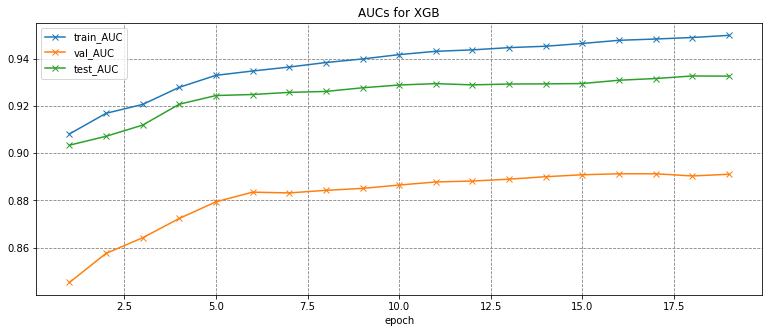

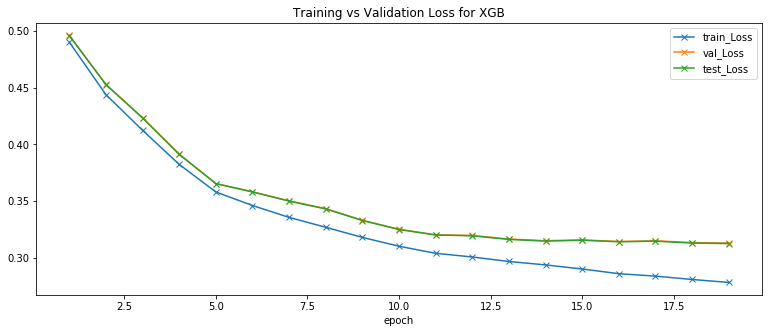

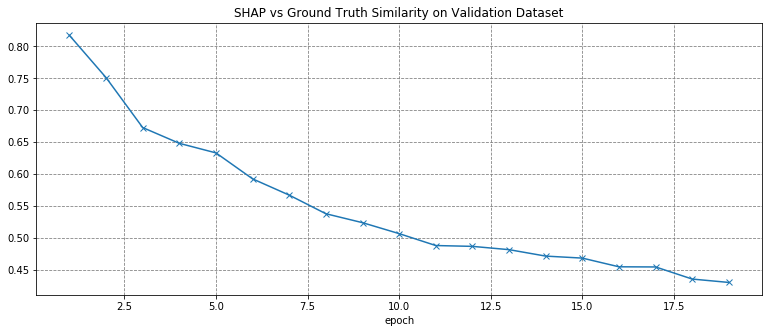

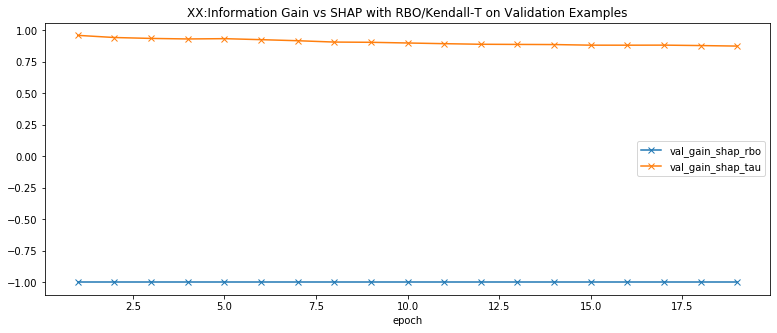

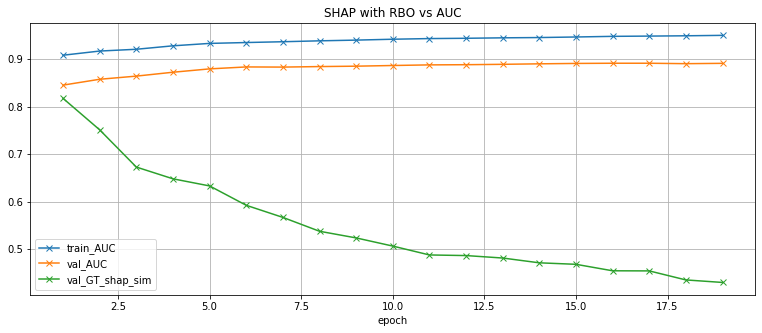

In [30]:
figsize = (13, 5)
df_results.reset_index().plot(
    figsize=figsize,
    x="epoch",
    y=["train_AUC", "val_AUC", "test_AUC"],
    kind="line",
    marker="x",
)
plt.title("AUCs for XGB")
plt.grid(color="gray", linestyle="--")

df_results.reset_index().plot(
    figsize=figsize,
    x="epoch",
    y=["train_Loss", "val_Loss", "test_Loss"],
    kind="line",
    marker="x",
)
plt.title("Training vs Validation Loss for XGB")

df_results.reset_index().plot(
    figsize=figsize,
    x="epoch",
    y=["val_GT_shap_sim"],
    kind="line",
    marker="x",
    legend=False,
)
plt.title("SHAP vs Ground Truth Similarity on Validation Dataset")
plt.grid(color="gray", linestyle="--")


df_results.reset_index().plot(
    figsize=figsize,
    x="epoch",
    y=["val_gain_shap_rbo", "val_gain_shap_tau"],
    kind="line",
    marker="x",
)
plt.title("XX:Information Gain vs SHAP with RBO/Kendall-T on Validation Examples")

# df_results.reset_index().plot(
#     figsize=figsize,
#     x="epoch",
#     y=["gain_permute_rbo", "gain_permute_tau"],
#     kind="line",
#     marker="x",
# )
# plt.title("Information Gain vs Permutation Importance with RBO/Kendall-T")

# df_results.reset_index().plot(
#     figsize=figsize,
#     x="epoch",
#     y=["gain_permute_rbo", "gain_permute_tau", "val_AUC"],
#     kind="line",
#     marker="x",
# )
# plt.title("Gain/Permutation with RBO/Kendall-T vs Validation AUC")


df_results.reset_index().plot(
    figsize=figsize,
    x="epoch",
    y=[
        "train_AUC",
        "val_AUC",
        "val_GT_shap_sim",
    ],
    kind="line",
    marker="x",
)
plt.title("SHAP with RBO vs AUC")
plt.grid()
plt.show()

# Save figures

In [32]:
plt.style.use("ggplot")

In [33]:
def ret_label_df(df, colname, dataset):
    len_epoch = df.shape[0]
    plot_df = df[["epoch", colname]].copy()
    plot_df.columns = ["epoch", "AUC"]
    plot_df["dataset"] = dataset

    return plot_df

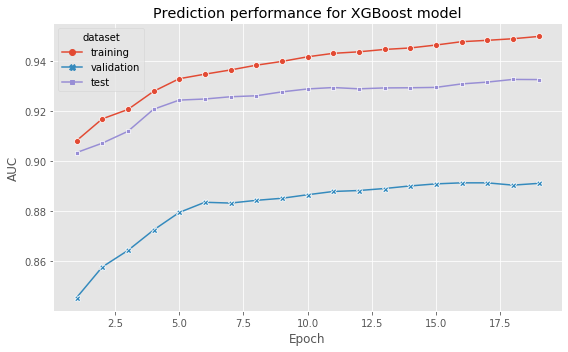

In [34]:
train_df = ret_label_df(df_results.reset_index(), "train_AUC", "training")
val_df = ret_label_df(df_results.reset_index(), "val_AUC", "validation")
test_df = ret_label_df(df_results.reset_index(), "test_AUC", "test")
plot_df = pd.concat([train_df, val_df, test_df])
plt.figure(figsize=(8, 5))
ax = sns.lineplot(
    data=plot_df,
    x="epoch",
    y="AUC",
    hue="dataset",
    markers=True,
    dashes=False,
    style="dataset",
)
ax.set_title("Prediction performance for XGBoost model")
ax.set_xlabel("Epoch")
plt.tight_layout()
plot_path = os.path.join(plot_save_dir, "XGB_auc_vs_epoch.png")
plt.savefig(plot_path, dpi=600)

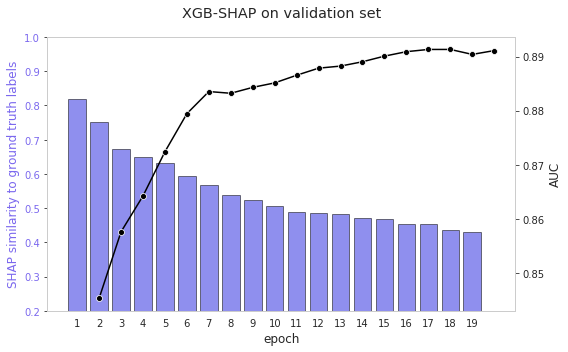

In [35]:
sns.set_style("whitegrid", {"axes.grid": False})
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=df_results.reset_index(),
    x="epoch",
    y="val_GT_shap_sim",
    color="blue",
    alpha=0.5,
    edgecolor="black",
    linewidth=1,
)
ax.set(ylim=(0.2, 1.0))
ax.set_xlabel("epoch")
ax.set_ylabel("SHAP similarity to ground truth labels", color="mediumslateblue")
for i, label in enumerate(ax.get_yticklabels()):
    label.set_color("mediumslateblue")
ax2 = ax.twinx()
sns.lineplot(
    data=df_results.reset_index(),
    x="epoch",
    y="val_AUC",
    ax=ax2,
    color="black",
    marker="o",
)
ax2.set_ylabel("AUC")
ax.set_title("XGB-SHAP on validation set")
ax.title.set_position([0.5, 1.05])
plt.tight_layout()
plot_path = os.path.join(plot_save_dir, "XGB_auc_vs_gt_SHAP_val.png")
plt.savefig(plot_path, dpi=600)

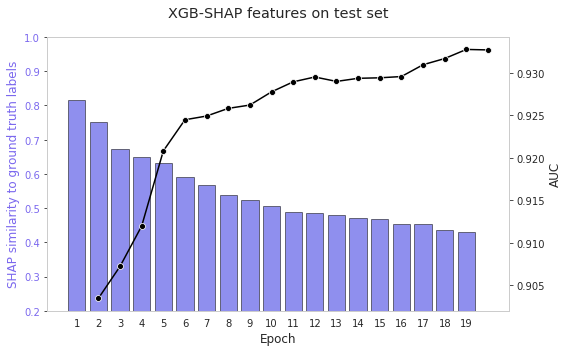

In [36]:
sns.set_style("whitegrid", {"axes.grid": False})
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=df_results.reset_index(),
    x="epoch",
    y="test_GT_shap_sim",
    color="blue",
    alpha=0.5,
    edgecolor="black",
    linewidth=1,
)
ax.set(ylim=(0.2, 1.0))
ax.set_xlabel("Epoch")
ax.set_ylabel("SHAP similarity to ground truth labels", color="mediumslateblue")
for i, label in enumerate(ax.get_yticklabels()):
    label.set_color("mediumslateblue")
ax2 = ax.twinx()
sns.lineplot(
    data=df_results.reset_index(),
    x="epoch",
    y="test_AUC",
    ax=ax2,
    color="black",
    marker="o",
)
ax2.set_ylabel("AUC")
ax.set_title("XGB-SHAP features on test set")
ax.title.set_position([0.5, 1.05])
plt.tight_layout()
plot_path = os.path.join(plot_save_dir, "XGB_auc_vs_gt_SHAP_test.png")
plt.savefig(plot_path, dpi=600)

# Visualize SHAP

In [37]:
def get_best_epoch(df, by="val_AUC"):
    """Get best epoch based on the given dataframe and column"""
    best_epoch = df_results[by].idxmax()
    best_epoch = int(best_epoch)
    return best_epoch

In [38]:
best_epoch = get_best_epoch(df_results)
best_epoch

17

In [39]:
split = "test"
new_path = shap_save_path_pattern.format(split, best_epoch)

In [43]:
len(features)

387

In [45]:
shap_values.shape

(10000, 387)

In [46]:
val_plot_df.iloc[:100000][features].shape

(100000, 387)

In [44]:
val_plot_df.head()

,patient_id,h_71020,h_93010,h_99284,h_A0425,h_A0427,h_99214,d_72887,d_V5869,h_36415,...,p_4414_rf,p_4621_rf,p_4603_rf,p_4679_rf,p_527_rf,p_5214_rf,p_4281_rf,p_5222_rf,p_44_rf,d_00845
0,TXW0XBNHS,1,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,HVJ6XSQQV,0,1,0,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,P81YE3JUU,2,3,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
3,Q9K9DMU8A,1,1,1,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,LBNMJ4ZIW,0,4,0,1,0,1,0,0,4,...,0,0,0,0,0,0,0,0,0,0


In [50]:
def get_shap_values_and_features_xgb(all_shap):
    all_features = []
    all_scores = []
    for pat_id, shap_info in all_shap.items():
        if not all_features:
            all_features = shap_info["features_xgb"]
        all_scores.append(shap_info["xgb_shap"])
    all_scores = np.array(all_scores)
    return all_features, all_scores


# with open(new_path, "rb") as fp:
#     all_shap = pickle.load(fp)
# features, shap_values = get_shap_values_and_features_xgb(all_shap)
# val_plot_df = pd.read_csv(x_valid_one_hot_path)
# # For summary plot
# shap.summary_plot(
#     shap_values,
#     val_plot_df.iloc[:100000][features],
#     feature_names=features,
#     max_display=30,
#     show=False,
# )
# fig = plt.gcf()
# Global Feature importance
# shap.summary_plot(shap_values, features=features, plot_type="bar")
# fig.set_size_inches(12, 15)
# plt.tight_layout()
# plot_path = os.path.join(
#     plot_save_dir, f"SHAP_XGB_Epoch{best_epoch}_global_{split}.png"
# )
# plt.savefig(plot_path, dpi=600)

## Plot similarity between global SHAP vs Information Gain

In [51]:
epochs = range(1, len(model_paths) + 1)
figsize = (8, 8)

rbo_corr = []
tau_corr = []
for epoch in [best_epoch]:
    shap_path = shap_save_path_pattern.format("val", epoch)
    mod_path = model_save_path.format(epoch)
    xgb_model = sj_utils.load_pickle(mod_path)
    val_results = sj_utils.load_pickle(shap_path)
    xgb_gain = pd.DataFrame((xgb_model.get_score(importance_type="gain")).items())
    xgb_gain.columns = ["features", "xgb_gain"]
    xgb_gain["xgb_gain_rank"] = xgb_gain["xgb_gain"].rank(ascending=False)

    df_shap = get_features_and_global_shap(val_results)
    df_shap.rename(columns={"scores": "shap_scores"}, inplace=True)
    df_shap["shap_rank"] = df_shap["shap_scores"].rank(ascending=False)

    gain_shap_df = xgb_gain[["features", "xgb_gain", "xgb_gain_rank"]].merge(
        df_shap[["features", "shap_scores", "shap_rank"]], how="inner", on="features"
    )

    #     rbo_score = rbo.RankingSimilarity(
    #         gain_shap_df.xgb_gain_rank.values, gain_shap_df.shap_rank.values
    #     ).rbo(p=p_rbo)
    #     rbo_corr.append(rbo_score)

    tau_score = get_wtau(gain_shap_df.xgb_gain, gain_shap_df.shap_scores)
    tau_corr.append(tau_score)

In [52]:
gain_shap_df.head()

,features,xgb_gain,xgb_gain_rank,shap_scores,shap_rank
0,discharge,265.318922,3.0,0.139480,6.0
1,d_78791,124.662194,5.0,0.262705,2.0
2,h_A0425,81.008025,6.0,0.177295,4.0
3,h_99308,29.442107,12.0,0.041060,21.0
4,h_87324,65.902100,8.0,0.133424,7.0


In [53]:
# Max tokens to display
MAX_TOKENS = 30

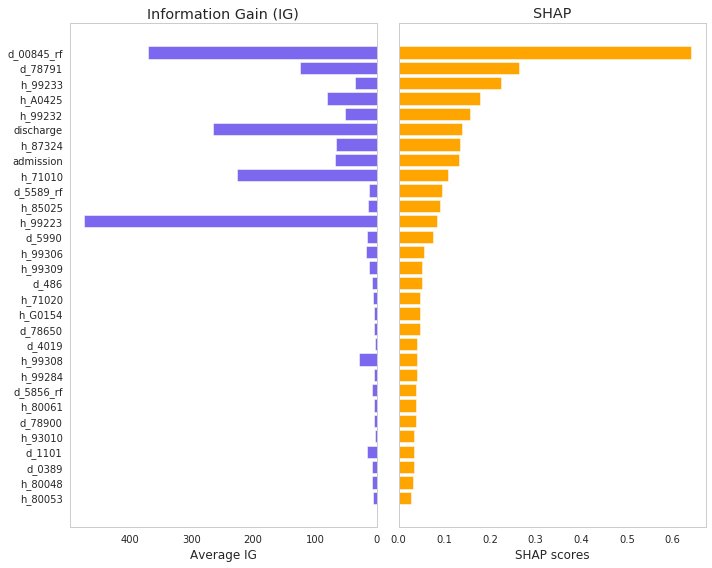

In [54]:
gain_shap_df = gain_shap_df.sort_values(
    "shap_scores", ascending=True, inplace=False
).reset_index(drop=True)

if MAX_TOKENS is not None:
    gain_shap_df = gain_shap_df.iloc[-MAX_TOKENS:]

# gain_shap_df.sort_values("shap_scores", ascending=True, inplace=True)

fig = plt.figure(figsize=(10, 8))
axes = fig.subplots(ncols=2, sharey=True)
#        row.bar(
#            df['features'], df[epoch_col], 0.8, label=epoch_col, color=color, edgecolor='black')
axes[0].barh(
    gain_shap_df.features,
    gain_shap_df.xgb_gain,
    color="mediumslateblue",
    align="center",
    zorder=10,
)
axes[0].set(title="Information Gain (IG)", xlabel="Average IG")
axes[1].barh(
    gain_shap_df.features, gain_shap_df.shap_scores, color="orange", align="center"
)
axes[1].set(title="SHAP", xlabel="SHAP scores")
axes[0].invert_xaxis()
# axes[1].set_yticks([])
fig.subplots_adjust(wspace=0.09)
plt.tight_layout()
plot_path = os.path.join(
    plot_save_dir, f"XGBoost_IG_SHAP_Epoch{best_epoch}_{split}.png"
)
plt.savefig(plot_path, dpi=600)

In [55]:
# rbo_corr = []
# tau_corr = []
# for epoch in epochs:
#     shap_path = shap_save_path_pattern.format("val", epoch)
#     mod_path = model_save_path.format(epoch)
#     xgb_model = sj_utils.load_pickle(mod_path)
#     val_results = sj_utils.load_pickle(shap_path)
#     xgb_gain = pd.DataFrame((xgb_model.get_score(importance_type="gain")).items())
#     xgb_gain.columns = ["features", "xgb_gain"]
#     xgb_gain["xgb_gain_rank"] = xgb_gain["xgb_gain"].rank(ascending=False)

#     df_shap = get_features_and_global_shap(val_results)
#     df_shap.rename(columns={"scores": "shap_scores"}, inplace=True)
#     df_shap["shap_rank"] = df_shap["shap_scores"].rank(ascending=False)

#     gain_shap_df = xgb_gain[["features", "xgb_gain", "xgb_gain_rank"]].merge(
#         df_shap[["features", "shap_scores", "shap_rank"]], how="inner", on="features"
#     )

#     rbo_score = rbo.RankingSimilarity(
#         gain_shap_df.xgb_gain_rank.values, gain_shap_df.shap_rank.values
#     ).rbo(p=p_rbo)
#     rbo_corr.append(rbo_score)

#     tau_score = get_wtau(gain_shap_df.xgb_gain, gain_shap_df.shap_scores)
#     tau_corr.append(tau_score)

# # plt.plot(epochs, tau_corr)

# Distribution of similarities

In [58]:
valpath = shap_save_path_pattern.format("val", best_epoch)
testpath = shap_save_path_pattern.format("test", best_epoch)

In [59]:
# calculate ground truth scores
def is_value(x, cdiff=False):
    outcome = False
    if cdiff:
        if x.endswith("_rf"):
            outcome = True
    else:
        if not x.endswith("_N"):
            outcome = True
    return outcome


def get_model_intersection_similarity_v3(
    features_scores, cdiff, absolute=True, freedom=1
):
    # gt similarity
    all_features, all_scores = features_scores[0], features_scores[1]
    sims = []
    for i, features in enumerate(all_features):
        scores = all_scores[i]
        gt_features = [feature for feature in features if is_value(feature, cdiff)]
        n_gt = len(gt_features)
        if n_gt > 0:
            dict_features_scores = sj_utils.create_dict_features_scores(
                features, scores, absolute
            )
            top_features_scores = sj_utils.top_k(
                dict_features_scores, len(gt_features) + freedom
            )
            top_features = top_features_scores[0]
            pred_features = [
                feature for feature in top_features if is_value(feature, cdiff)
            ]
            sim = len(set(pred_features).intersection(gt_features)) / float(n_gt)
        else:
            sim = -1
        sims.append(sim)
    avg_sim = sum(sims) / len(sims)
    return avg_sim, sims

In [60]:
with open(valpath, "rb") as fp:
    all_shap = pickle.load(fp)
val_features, val_shap_values = get_shap_values_and_features_xgb(all_shap)

with open(testpath, "rb") as fp:
    all_shap = pickle.load(fp)
tst_features, tst_shap_values = get_shap_values_and_features_xgb(all_shap)

In [61]:
avg_sim, val_sim = get_model_intersection_similarity_v3(
    ([val_features] * len(val_shap_values), val_shap_values),
    absolute=True,
    cdiff=True,
)

avg_sim, tst_sim = get_model_intersection_similarity_v3(
    ([tst_features] * len(tst_shap_values), tst_shap_values),
    absolute=True,
    cdiff=True,
)

In [62]:
pd.DataFrame(val_sim).describe()

,0
count,10000.000000
mean,0.454367
std,0.015465
min,0.414847
25%,0.441048
50%,0.454148
75%,0.467249
max,0.497817


In [63]:
pd.DataFrame(tst_sim).describe()

,0
count,10000.000000
mean,0.454224
std,0.015563
min,0.419214
25%,0.441048
50%,0.454148
75%,0.467249
max,0.502183


In [46]:
# pip install -U seaborn

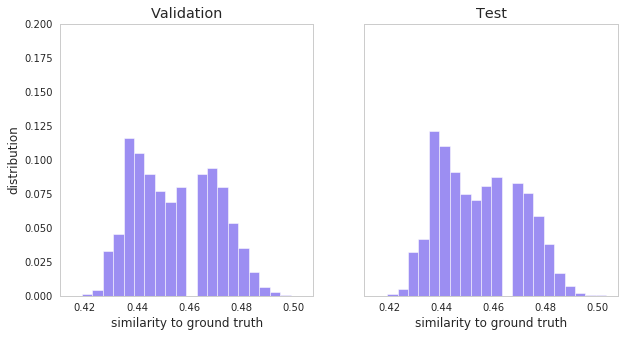

In [65]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, sharex=True, figsize=(10, 5))
sns.histplot(
    val_sim, ax=ax1, binwidth=0.004, color="mediumslateblue", stat="probability"
)
ax1.set_xlabel("similarity to ground truth")
ax1.set_title("Validation")
ax1.set_ylabel("distribution")
ax1.set_ylim([0.0, 0.2])
sns.histplot(
    tst_sim,
    ax=ax2,
    bins=100,
    binwidth=0.004,
    color="mediumslateblue",
    stat="probability",
)
ax2.set_xlabel("similarity to ground truth")
ax2.set_title("Test")
plot_path = os.path.join(plot_save_dir, "XGB_sim_dist.png")
plt.savefig(plot_path, dpi=600)

## Plot Global Importance per Epoch

In [66]:
# epochs = range(1, len(model_paths) + 1)
# figsize = (15, 10)
# for epoch in epochs:
#     shap_path = shap_save_path_pattern.format("val", epoch)
#     print(shap_path)
#     val_results = sj_utils.load_pickle(shap_path)
#     df_shap = get_features_and_global_shap(val_results)
#     df_shap = df_shap.sort_values("scores", ascending=True)
#     df_shap.plot(
#         figsize=figsize,
#         x="features",
#         y="scores",
#         kind="barh",
#     )
#     plt.title(f"Global Feature Importance (epoch={epoch})")
#     plt.show()

In [67]:
with open(examples_path, "r") as fp:
    selected_patients = fp.readlines()
    selected_patients = [pat.strip() for pat in selected_patients]

selected_patients

['SH8FMNYIU', 'RMUKOV6H2']

In [68]:
# n_jobs = len(model_paths)
# # step = int(n_jobs / 2) - 1
# # epochs = range(1, len(model_paths) + 1, 2)
# epochs = [best_epoch]  # n_jobs+1) #range(1, len(model_paths) + 1, step)
# for patient_id in selected_patients:
#     df = pd.DataFrame()
#     label = None
#     pred_prob = None
#     for epoch in epochs:
#         shap_path = shap_save_path_pattern.format("test", epoch)
#         test_results = sj_utils.load_pickle(shap_path)
#         if not len(df):
#             features = test_results[patient_id]["features_xgb"]
#             df["features"] = features
#             df["values"] = df_test[features][
#                 df_test["patient_id"] == patient_id
#             ].values[0]
#             df["features"] = df["values"].astype(str) + "_" + df["features"]
#             if test_results[patient_id]["xgb_pred"] > 0.5: #Dirty fix (need to update this in the final)
#                 label = 1
#             else:
#                 label = 0
#             #label = test_results[patient_id]["label"]
#         pred_prob = test_results[patient_id]["xgb_pred"]
#         df[f"epoch_{epoch}"] = test_results[patient_id]["xgb_shap"]
#     figsize = (15, 10)
#     epoch_cols = [f"epoch_{epoch}" for epoch in epochs]
#     df.plot(
#         figsize=figsize,
#         x="features",
#         y=epoch_cols,
#         kind="bar",
#         width=0.8,
#     )
#     plt.title(f"SHAP Scores for {patient_id}: label={label}, pred={pred_prob:.4}")
#     plt.show()

In [70]:
df_results

,train_AUC,val_AUC,test_AUC,train_Loss,val_Loss,test_Loss,gain_permute_rbo,gain_permute_tau,val_GT_shap_sim,test_GT_shap_sim,val_gain_shap_rbo,val_gain_shap_tau
epoch,,,,,,,,,,,,
1,0.908190,0.845264,0.903440,0.490055,0.496035,0.495790,-1.0,NaN,0.817395,0.817359,-1.0,0.961110
2,0.916945,0.857581,0.907203,0.443773,0.452827,0.452616,-1.0,NaN,0.751157,0.751155,-1.0,0.943967
3,0.920712,0.864212,0.911954,0.412346,0.423419,0.423215,-1.0,NaN,0.672860,0.672956,-1.0,0.936794
4,0.927972,0.872392,0.920803,0.382310,0.391331,0.391178,-1.0,NaN,0.648140,0.648203,-1.0,0.932525
5,0.933042,0.879437,0.924476,0.358013,0.365443,0.365330,-1.0,NaN,0.633158,0.633221,-1.0,0.934872
6,0.934869,0.883524,0.924913,0.346072,0.358228,0.358010,-1.0,NaN,0.592422,0.592339,-1.0,0.926916
7,0.936555,0.883204,0.925815,0.335602,0.350205,0.349966,-1.0,NaN,0.566947,0.566861,-1.0,0.918496
8,0.938461,0.884296,0.926207,0.326902,0.343317,0.343093,-1.0,NaN,0.537776,0.537599,-1.0,0.907854
9,0.939970,0.885125,0.927761,0.317975,0.333075,0.332846,-1.0,NaN,0.523769,0.523586,-1.0,0.905939


In [71]:
# best_epoch_shap = get_best_epoch(df_results, by="val_GT_shap_sim")
# best_epoch_shap

1

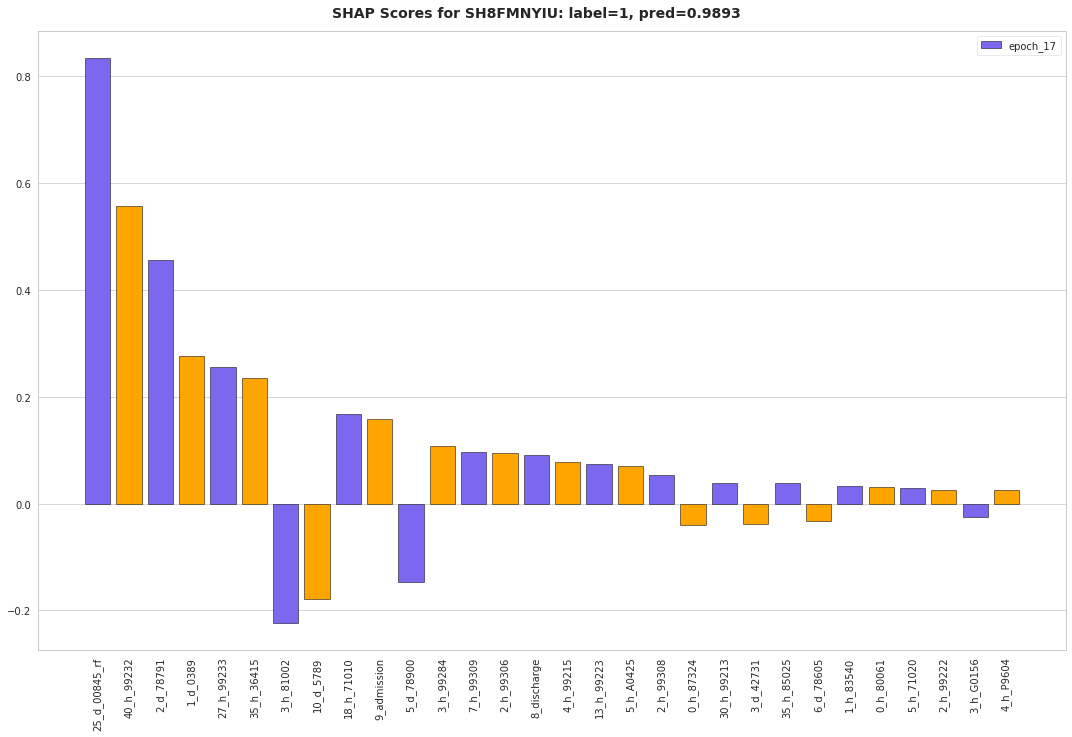

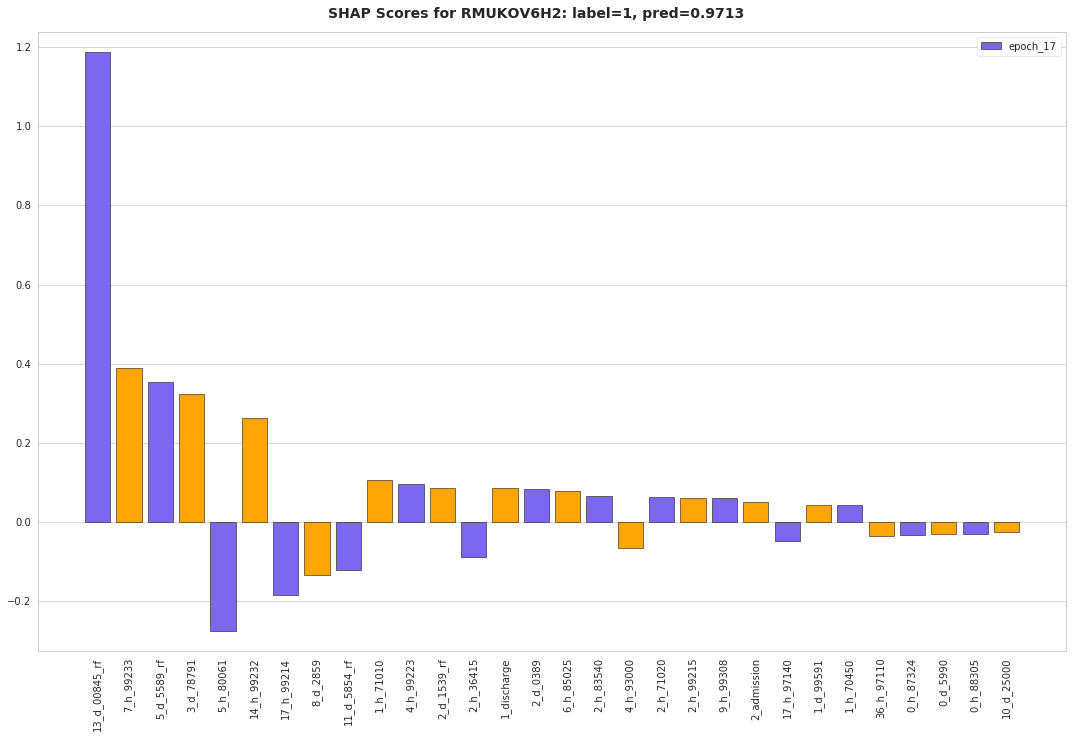

In [72]:
epochs = sorted([best_epoch])
for patient_id in selected_patients:  # sel_patients_2:
    df = pd.DataFrame()
    label = None
    pred_prob = None
    for epoch in epochs:
        shap_path = shap_save_path_pattern.format("test", epoch)
        test_results = sj_utils.load_pickle(shap_path)
        if not len(df):
            features = test_results[patient_id]["features_xgb"]
            df["features"] = features
            df["values"] = df_test[features][
                df_test["patient_id"] == patient_id
            ].values[0]
            df["features"] = df["values"].astype(str) + "_" + df["features"]
            if (
                test_results[patient_id]["xgb_pred"] > 0.5
            ):  # Dirty fix (need to update this in the final)
                label = 1
            else:
                label = 0
            # label = test_results[patient_id]["label"]
        pred_prob = test_results[patient_id]["xgb_pred"]
        df[f"epoch_{epoch}"] = test_results[patient_id]["xgb_shap"]

    figsize = (15, 10)
    epoch_cols = [f"epoch_{epoch}" for epoch in epochs]

    #     import pdb; pdb.set_trace()
    fig = plt.figure(figsize=figsize)
    axes = fig.subplots(nrows=1, ncols=1)
    min_y, max_y = (
        df[epoch_cols].values.min() - 0.05,
        df[epoch_cols].values.max() + 0.05,
    )
    # for row, epoch_col, color in zip(axes, epoch_cols, ["mediumslateblue", "orange"]):
    row, epoch_col, color = axes, epoch_cols[0], ["mediumslateblue", "orange"]
    if MAX_TOKENS is not None:
        idx = np.argsort(np.abs(df[epoch_col].values))[::-1]
        df = df.iloc[idx]
        df = df.iloc[:MAX_TOKENS]

    row.bar(
        df["features"],
        df[epoch_col],
        0.8,
        label=epoch_col,
        color=color,
        edgecolor="black",
    )
    if epoch_col != epoch_cols[-1]:
        row.set_xticks([])
    else:
        row.set_xticklabels(df["features"].tolist(), rotation=90)
    row.grid(axis="y")
    row.set_ylim((min_y, max_y))
    row.legend()

    plt.tight_layout()
    st = fig.suptitle(
        f"SHAP Scores for {patient_id}: label={label}, pred={pred_prob:.4}",
        fontsize=14,
        fontweight="bold",
    )
    # st.set_y(0.95)
    st.set_y(1.02)
    fig.subplots_adjust(top=0.90)

    plt.tight_layout()
    plot_path = os.path.join(
        plot_save_dir, "XGB_perpatient_" + patient_id + f"_label{label}.png"
    )
    plt.savefig(plot_path, dpi=600, bbox_inches="tight")
    plt.show()